# Clustering

Vamos a implementar el modelo del paper [Multilingual E5 Text Embeddings: A Technical Report](https://arxiv.org/pdf/2402.05672) para construir embebimientos de cada tweet y luego visualizarlos.

In [2]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [3]:
# pip install transformers

In [4]:
# pip install tidyX

In [5]:
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from tidyX import TextPreprocessor as tp

import os
import pickle
import pandas as pd
import numpy as np

In [6]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [7]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

In [8]:
# We load the tweets
archivos = os.listdir('/mnt/disk2/Data/Tweets_DataFrames/Tweets_Paro_Total')
# Do a test with one file
df = pd.read_pickle(r'/mnt/disk2/Data/Tweets_DataFrames/Tweets_Paro_Total/tweets_paro_1.gzip', compression = 'gzip')
df = df.reset_index(drop = True)

In [9]:
archivos

['tweets_paro_4.gzip',
 'tweets_paro_5.gzip',
 'tweets_paro_3.gzip',
 'tweets_paro_7.gzip',
 'tweets_paro_2.gzip',
 'tweets_paro_6.gzip',
 'tweets_paro_1.gzip']

In [11]:
# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.

input_texts = df.loc[0:100, "Text"]
input_texts = input_texts.apply(lambda x: tp.preprocess(str(x)))
input_texts = "passage: " + input_texts
input_texts = input_texts.values
input_texts = input_texts.tolist()

In [18]:
len(input_texts)

101

In [13]:
# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length = 512, padding = True, truncation = True, return_tensors = 'pt')

In [33]:
outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [40]:
# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)

In [50]:
from sklearn.cluster import KMeans
n_clusters = 3 

kmeans = KMeans(n_clusters = n_clusters, random_state = 666)
kmeans.fit(embeddings.detach().numpy())

cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [51]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [52]:
tsne = TSNE(n_components = 2, random_state = 666)
embeddings_2d = tsne.fit_transform(embeddings.detach().numpy())

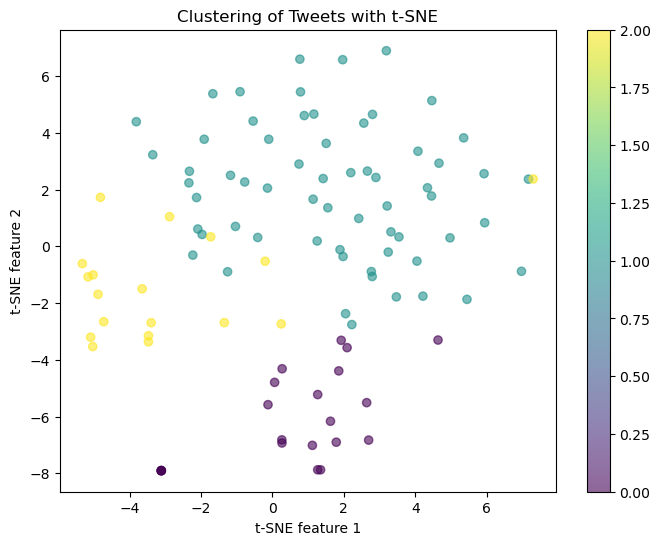

In [53]:
plt.figure(figsize = (8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c = cluster_labels, cmap = 'viridis', alpha = 0.6)
plt.colorbar(scatter)
plt.title('Clustering of Tweets with t-SNE')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [57]:
np.array(input_texts)[cluster_labels == 0]

array(['passage: un adulto mayor resulto afectado tras intervencion del esmad en suba',
       'passage: que tal funciona la justicia colombiana ya le muestro',
       'passage: persiste la represion del esmad contra manifestantes en fontanar suba',
       'passage: ', 'passage: construyendo el por todo el caribe',
       'passage: que tal dificil es',
       'passage: atencion el alcalde de jamundi acaba de declarar alerta roja hospitalaria',
       'passage: jim mcgovern que nada de nuestro dinero vaya a la policia de colombia',
       'passage: no se necesitan palabras',
       'passage: este esquema lo convirtieron en politica estatal',
       'passage: pero sobre todo es hijueputa', 'passage: ',
       'passage: esto es de no creer esto es absurdo e irrespetuoso',
       'passage: no quedaran en el olvido',
       'passage: lo logramos ayer llegamos a la jep donde termina la cifra de',
       'passage: ',
       'passage: esto de esos miembros del esmad es de salvajes',
       'pa

In [58]:
np.array(input_texts)[cluster_labels == 1]

array(['passage: otra persona sufriendo convulsiones en fontanar producto de la represion usted dio la orden',
       'passage: aqui les informamos en este preciso momento en inmediaciones del parque fontanar en la localidad de suba en bogota se vive una violenta represion policial ya se reportan varios heridos y desaparecidos fuente tropa digital pablo ubedani',
       'passage: andres cardona reportero grafico de y de varios medios internacionales acaba de ser atacado por el esmad en suba via',
       'passage: maria jovita osorio de anos murio en cali luego de que un proyectil de gas lacrimogeno se dispersara por su casa y le provocara fallos seguidos en el corazon',
       'passage: no se les olvide prendan notificaciones del que va a estar tremendo descuentos beneficios y cosas hermosas apoyen con un rt que todos conozcan los emprendimientos participantes',
       'passage: en acaba de fallecer nuestro hermano zacarias llego de ayacucho junto a delegacion para defender la voluntad

In [59]:
np.array(input_texts)[cluster_labels == 2]

array(['passage: increible la ordena ampliar denuncia contra por dar proteccion a jovenes indefensos contra la brutalidad del esmad y se abstiene de llamar a juicio a marta lucia ramirez por vinculos comerciales con el memo fantasma y con el sr salvatore mancuso',
       'passage: tan acuciosa la fiscalia sera q nos puede informar en q va o q se sabe o q se puede saber d la investigacion al sr d ciudad jardin andres escobar q disparo contra manifestantes avanza la investigacion la pregunta viene a lugar a proposito d la investigacion a',
       'passage: hola ya que estamos hablando de crimenes y vandalos podemos hablar de tu secretario de seguridad en medellin quien fue capturado por presuntas relaciones con criminales tu le tenias mucha confianza le decias tavo a gustavo villegas',
       'passage: senora claudia lopez alcaldesa de bogota los cascos guantes y gafas que fueron dados a la primera linea son para evitar que usted como comandante de la policia en la capital ordene acribil